In [2]:
%matplotlib widget
import control as ct
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
# plt.rcParams["animation.html"] = "jshtml"

import hydrostat_cell as hc
import hydrostat_arm as ha
import draw_nodes

import importlib

# Individual Cells

Individual cells connect with each other to create one connected "tissue". A cell consists of vertices and muscles (edges).

A cell always maintains a constant volume. Forces act on vertices and any changes in volume are compensated by the free vertices. If a cell is overconstrained, then movement is not possible. 

c:\Users\Alex\Documents\_projTech\030_isochoric\src\draw_nodes.py:46: UserWarning: frames=<bound method NodeDrawer.infinite_frames of <draw_nodes.NodeDrawer object at 0x000001445062E360>> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = FuncAnimation(


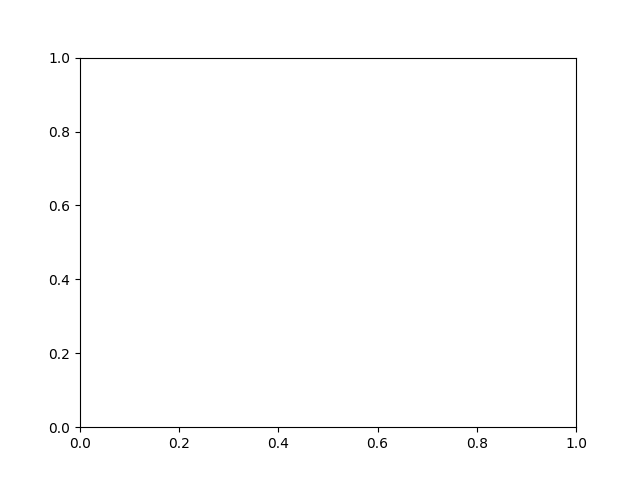

In [3]:
importlib.reload(ha)
importlib.reload(draw_nodes)

vertices = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 2],
    [1, 2],
    [0, 3],
    [1, 3],
    [0, 4],
    [1, 4],
    [0, 5],
    [1, 5]
])
cells = np.array([
    [0, 1, 2],
    [1, 2, 3],
    [2, 3, 4],
    [3, 4, 5],
    [4, 5, 6],
    [5, 6, 7],
    [6, 7, 8],
    [7, 8, 9],
    [8, 9, 10],
    [9, 10, 11]
])
arm = ha.HydrostatArm(vertices, cells)
# arm.actuate_muscle(0, 1)
# arm.actuate_muscle(1, -.5)
# arm.actuate_muscle(2, 1)
# arm.actuate_muscle(3, 1)
# arm.actuate_muscle(5, -0.5)
# arm.actuate_muscle(6, 1)
# arm.actuate_muscle(7, 1)
# arm.actuate_muscle(9, -0.5)
# arm.actuate_muscle(10, 1)

# arm.actuate_muscle(0, 1)
# # arm.actuate_muscle(1, 1)

# arm.actuate_muscle(3, 1)
# arm.actuate_muscle(7, 1)
# arm.actuate_muscle(11, 1)
# arm.actuate_muscle(15, 1)
# arm.actuate_muscle(19, 1)
# arm.apply_external_force(2, [0, 1])
drawer = draw_nodes.NodeDrawer(arm)

In [4]:
# Constrained Optimization
"""an arm is made of multiple cells
each cell has 3 vertices with mass and damping and 3 edges
each cell has a volume constraint
some cells have vertices with constraints

The arm has a combined state vector of all vertices
The arm has a combined list of edges
The arm has a constraint matrix
    This constraint matrix has all the volume constraints and boundary conditions

It constructs a jacobian as well as the derivative jacobian
    
"""

simulation_steps = 1000
dt = 0.01
t = np.arange(0, (simulation_steps+1) * dt, dt)

dim = 2
q0 = np.array([0, 0, 1, 0, 0, 1, 1, 1])
num_nodes = len(q0)//dim
dq0 = np.zeros(num_nodes * dim)
M = np.diag(np.ones(num_nodes * dim))
W = np.linalg.inv(M)
B = np.diag(np.ones(num_nodes * dim))
Q = np.zeros((simulation_steps, num_nodes*dim))
# Q[:,5] = -np.ones((simulation_steps))/2
# Q[:,2] = -np.ones((simulation_steps))/2
# Q[:,3] = np.ones((simulation_steps))/2
F = np.zeros((simulation_steps, 5))
ks = 1
kd = 1

def cell_volume(q):
    return 0.5 * np.abs((q[2] - q[0]) * (q[5] - q[1]) - (q[3] - q[1]) * (q[4] - q[0]))

def C(q):
    """Returns an mx1 numpy array of constraints. Each constraint is set equal
    to zero."""
    return np.array([
        cell_volume(q[0:6]) - cell_volume(q0[0:6]),
        q[0],
        q[1],
        cell_volume(q[2:8]) - cell_volume(q0[2:8]),
    ])

def jacobian(q):
    """Returns an m x n jacobian where m is the number of constraints and n is
    the length of the state vector. Each element is the partial derivative
    pC_i/pq_j"""
    return np.array([[
        0.5*(q[3] - q[5]),
        0.5*(q[4] - q[2]),
        0.5*(q[5] - q[1]),
        0.5*(q[0] - q[4]),
        0.5*(q[1] - q[3]),
        0.5*(q[2] - q[0]),
        0, 0],

        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        
        [0, 0,
        0.5*(q[5] - q[7]),
        0.5*(q[6] - q[4]),
        0.5*(q[7] - q[3]),
        0.5*(q[2] - q[6]),
        0.5*(q[3] - q[5]),
        0.5*(q[4] - q[2])],
        ])

def dJ(q, dq):
    """Returns an m x n matrix of derivatives dJ/dt. This would technically be
    a rank 3 tensor, but can be represented by the mxn p(pC/pq dq/dt)/pq"""
    return np.array([[
        0.5*(dq[3] - dq[5]),
        0.5*(dq[4] - dq[2]),
        0.5*(dq[5] - dq[1]),
        0.5*(dq[0] - dq[4]),
        0.5*(dq[1] - dq[3]),
        0.5*(dq[2] - dq[0]),
        0, 0],

        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],

        [0, 0,
        0.5*(dq[5] - dq[7]),
        0.5*(dq[6] - dq[4]),
        0.5*(dq[7] - dq[3]),
        0.5*(dq[2] - dq[6]),
        0.5*(dq[3] - dq[5]),
        0.5*(dq[4] - dq[2])],
    ])

qs = np.empty((simulation_steps+1, num_nodes*dim))
dqs = np.empty((simulation_steps+1, num_nodes*dim))
qs[0] = q0
dqs[0] = dq0

for idx in range(simulation_steps):
    q = qs[idx]
    dq = dqs[idx]
    J = jacobian(q)
    lagrange_mult = (
        np.linalg.inv(J @ W @ J.T)
        @ ((J @ W @ B - dJ(q, dq)) @ dq - J @ W @ Q[idx])# - ks * C(q) - kd * J @ dq)
    )


    reactions = J.T @ lagrange_mult
    ddq = W @ (Q[idx] + reactions) - W @ B @ dq
    dqs[idx+1] = dq + ddq * dt
    qs[idx+1] = q + dq * dt


In [5]:
cell_volumes = cell_volume(qs.T[0:6])
max_vol_error = np.max(np.abs(cell_volumes - cell_volumes[0]))
print(max_vol_error)

cell_volumes = cell_volume(qs.T[2:8])
max_vol_error = np.max(np.abs(cell_volumes - cell_volumes[0]))
print(max_vol_error)

0.0009828929861483982
0.0007012108371922121


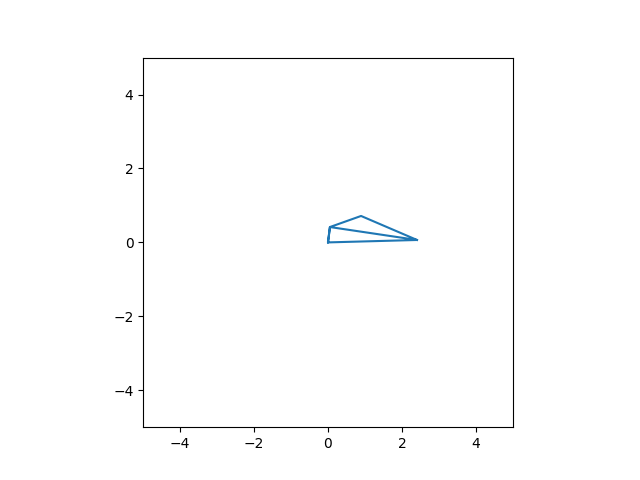

In [6]:
def get_triangle_coords(q):
    return ([q[0], q[2], q[4], q[0]], [q[1], q[3], q[5], q[1]])

def get_net_coords(q):
    return ([q[0], q[2], q[4], q[0], q[4], q[6], q[2]], [q[1], q[3], q[5], q[1], q[5], q[7], q[3]])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
# tri, = ax.plot(*get_triangle_coords(qs[0]))
net, = ax.plot(*get_net_coords(qs[0]))
arrow = ax.arrow(qs[0,2], qs[0,3], Q[0,2], Q[0,3], length_includes_head=True, head_width=.1)


def update(frame):
    # tri.set_data(*get_triangle_coords(qs[frame]))
    net.set_data(*get_net_coords(qs[frame]))
    arrow.set_data(x=qs[frame, 2], y=qs[frame, 3], dx=Q[frame, 2], dy=Q[frame, 3])
    return net, arrow,

ani = animation.FuncAnimation(fig, update, frames=simulation_steps, interval=10)
ani.save('triangle_animation.mp4')


C:\Users\Alex\AppData\Local\Temp\ipykernel_7396\2871914732.py:40: UserWarning: frames=<function infinite_frames at 0x00000144458EDE40> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, animate, frames=infinite_frames, interval=20, blit=True)


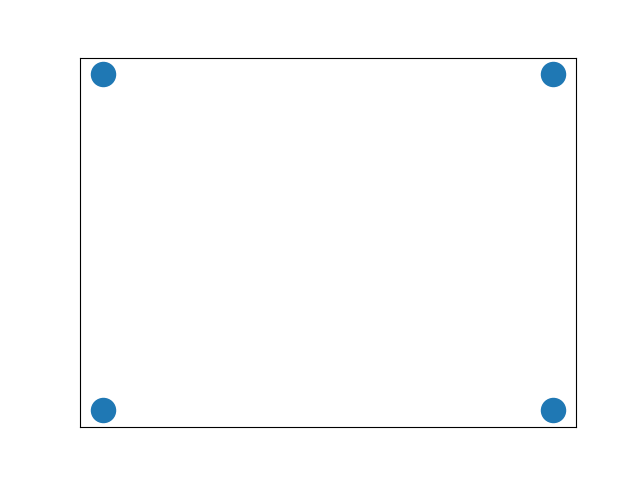

stopping


In [5]:
%matplotlib widget
import networkx as nx
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

vertices = [[0, 0], [1, 0], [0, 1], [1, 1]]
edges = [(0, 1), (1, 2), (2, 0), (1, 3), (3, 2)]
G = nx.Graph()
for i, vertex in enumerate(vertices):
    G.add_node(i, pos=vertex)
G.add_edges_from(edges)
pos = nx.get_node_attributes(G, "pos")


fig, ax = plt.subplots()
nodes = nx.draw_networkx_nodes(G, pos, ax=ax)
stop_animation = False

def on_press(event):
    print("stopping")
    stop_animation = True
    ani.event_source.stop()
fig.canvas.mpl_connect("button_press_event", on_press)


def infinite_frames():
    frame = 0
    while not stop_animation:
        yield frame
        frame += 1

def animate(frame):
    ax.clear()
    pos[3] = [1, frame/10]
    # G.nodes[3]["pos"] = tuple(pos[3])
    nx.draw(G, pos, ax=ax)

ani = FuncAnimation(fig, animate, frames=infinite_frames, interval=20, blit=True)

In [ ]:
ani.save("test.mp4")

NameError: name 'ani' is not defined